# Effect of Stride and Padding on CNN Feature Extraction (MNIST)
### Machine Learning & Neural Networks – Individual Assignment  
#### Stuent id - 24091783

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Training set:", x_train.shape)
print("Test set:", x_test.shape)


Training set: (60000, 28, 28, 1)
Test set: (10000, 28, 28, 1)


## Model Builder Function
We create a CNN where only **stride** or **padding** changes.  
All other layers remain identical so we can isolate the effect of these parameters.


In [11]:
def build_cnn(stride=1, padding="same"):
    inputs = Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, kernel_size=(3,3), strides=stride, padding=padding, activation="relu")(inputs)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(64, kernel_size=(3,3), strides=stride, padding=padding, activation="relu")(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


## Training Four CNN Models
We compare four configurations:

1. **Stride = 1, Padding = 'same'**  
2. **Stride = 2, Padding = 'same'**  
3. **Stride = 1, Padding = 'valid'**  
4. **Stride = 2, Padding = 'valid'**  

We train all models for 3 epochs.


In [12]:
configs = [
    (1, "same"),
    (2, "same"),
    (1, "valid"),
    (2, "valid")
]

histories = {}
models_dict = {}

for stride, pad in configs:
    print(f"\nTraining model (stride={stride}, padding={pad})")
    model = build_cnn(stride=stride, padding=pad)
    models_dict[(stride, pad)] = model

    history = model.fit(
        x_train, y_train,
        epochs=3,
        batch_size=64,
        validation_data=(x_test, y_test),
        verbose=1
    )

    histories[(stride, pad)] = history



Training model (stride=1, padding=same)
Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - accuracy: 0.9521 - loss: 0.1545 - val_accuracy: 0.9860 - val_loss: 0.0439
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.9860 - loss: 0.0454 - val_accuracy: 0.9889 - val_loss: 0.0379
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9902 - loss: 0.0317 - val_accuracy: 0.9889 - val_loss: 0.0324

Training model (stride=2, padding=same)
Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9116 - loss: 0.2945 - val_accuracy: 0.9693 - val_loss: 0.0981
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9704 - loss: 0.0959 - val_accuracy: 0.9797 - val_loss: 0.0620
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9778 - loss: 0.0710 - val_accuracy: 0.9828 - val_loss: 0.0547

Training model (stride=1, padding=valid)
Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9513 - loss: 0.1622 - val_accuracy:

## Validation Accuracy Comparison  
We visualise how stride and padding influence validation accuracy.


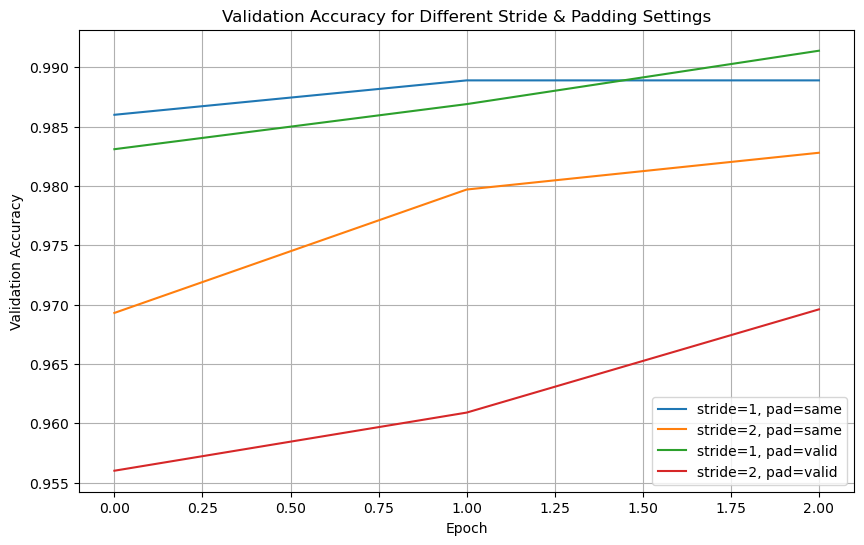

Saved: stride_padding_accuracy.png


In [13]:
plt.figure(figsize=(10,6))

for (stride, pad), history in histories.items():
    plt.plot(history.history["val_accuracy"], label=f"stride={stride}, pad={pad}")

plt.title("Validation Accuracy for Different Stride & Padding Settings")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()

plt.savefig("stride_padding_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: stride_padding_accuracy.png")


## Feature Map Visualisation
To understand how stride and padding affect feature extraction,  
we extract feature maps from the **first convolution layer**.

We use the model with:
- **stride = 1**
- **padding = 'same'**

as it preserves spatial resolution and is the most common configuration in modern CNNs.


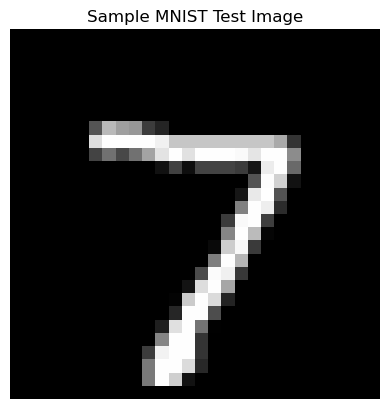

In [14]:
plt.imshow(x_test[0].squeeze(), cmap="gray")
plt.title("Sample MNIST Test Image")
plt.axis("off")

plt.savefig("sample_mnist_stride_padding.png", dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


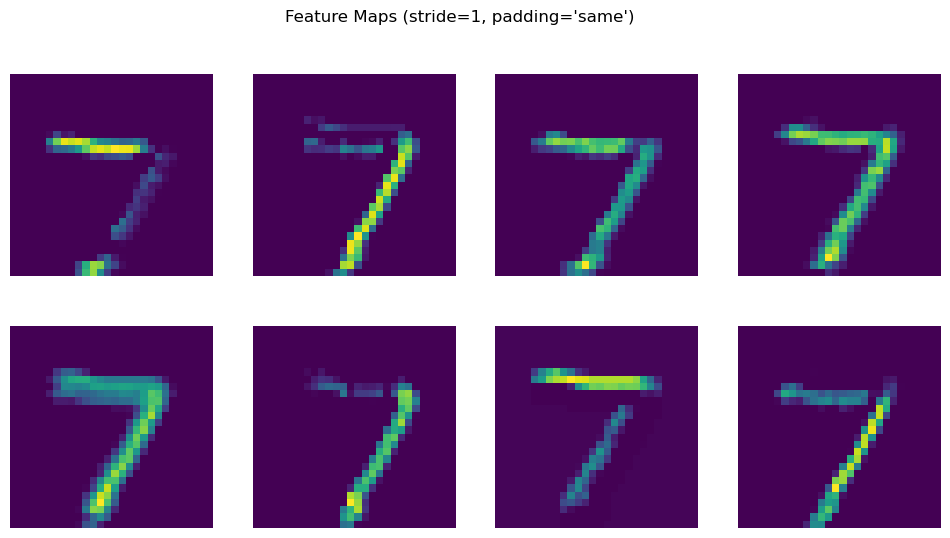

Saved: feature_maps_stride1_same.png


In [15]:
# Choose model with stride=1, padding="same"
model = models_dict[(1, "same")]

# Build the model graph
model(x_train[:1])

# First Conv Layer = model.layers[1]
first_conv_output = model.layers[1].output

# Activation model
activation_model = models.Model(inputs=model.input, outputs=first_conv_output)

# Predict
img = np.expand_dims(x_test[0], 0)
feature_maps = activation_model.predict(img)[0]

# Plot first 8 maps
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(feature_maps[..., i], cmap="viridis")
    plt.axis("off")

plt.suptitle("Feature Maps (stride=1, padding='same')")
plt.savefig("feature_maps_stride1_same.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: feature_maps_stride1_same.png")


## Output Feature Map Size Differences

Stride and padding change output resolution:

- **Stride 1 + Same** → keeps same spatial size  
- **Stride 1 + Valid** → shrinks output by removing borders  
- **Stride 2 + Same** → reduces size while keeping borders  
- **Stride 2 + Valid** → shrinks aggressively  

We calculate output shapes directly.


In [16]:
for key, model in models_dict.items():
    stride, pad = key
    model(x_train[:1])  # Build model
    print(f"stride={stride}, pad={pad} → final feature map size: {model.layers[3].output.shape}")


stride=1, pad=same → final feature map size: (None, 14, 14, 64)
stride=2, pad=same → final feature map size: (None, 4, 4, 64)
stride=1, pad=valid → final feature map size: (None, 11, 11, 64)
stride=2, pad=valid → final feature map size: (None, 2, 2, 64)
